# 텐서플로로만 구현하는 선형 회귀 예제  

## 변수 Variables

- **딥러닝 학습에서 최적화 과정**

  - 모델의 매개변수(parameters) 즉, 가중치(및 편향)를 조정하는 것

- **변수 tf.Variable**

  - 프로그램에 의해 변화하는 공유된 지속 상태를 표현하는 가장 좋은 방법

    - 하나의 텐서를 표현
    - 텐서 값은 텐서에 연산을 수행하여 변경 가능  

  - 모델 파라미터를 저장하는 데 tf.Variable을 사용  

- **변수 생성**
 
  - 변수를 생성하려면 단순하게 초기값을 설정

  ```py
  import tensorflow as tf

  # 1) 문제와 정답 데이터 저장
  x_train = [1, 2, 3, 4]
  y_train = [2, 4, 6, 8]

  # 2) 모델 구성(생성)
  # 선형회귀 모델(Wx + b)을 위한 tf.Variable을 선언합니다.
  w = tf.Variable(tf.random.normal(shape=[1]))    # 반드시 초기값 지정
  b = tf.Variable(tf.random.normal(shape=[1]))
  ```

## 텐서플로 함수로 회귀 구현

- **@tf.function**

  - 데코레이터
  - 다른 일반 함수들처럼 사용

    - 그래프 내에서 컴파일 되었을 때에는 더 빠르게 실행하고, GPU나 TPU를 사용해서 작동
    - TF 2.0 버전은 즉시 실행 (eager execution)의 편리함과 TF 1.0의 성능을 합침
    - 파이썬 문법의 일부를 이식 가능하고 높은 성능의 텐서플로 그래프 코드로 변환

  - 데코레이터가 붙은 함수로 부터 호출된 모든 함수들은 그래프 모드에서 동작
    
    - 모든 함수에 데코레이터를 붙일 필요는 없음  

  
  ```py
  @tf.function
  def linear_model(x):
    return W*x + b

  # ③ 학습에 필요한 최적화 방법과 손실 함수 등 지정
  # 최적화를 위한 그라디언트 디센트 옵티마이저를 정의합니다.
  optimizer = tf.optimizers.SGD(0.01)

  # 손실 함수를 정의합니다. MSE 손실함수 \mean{(y' - y)^2}
  @tf.function
  def mse_loss(y_pred, y):
    return tf.reduce_mean(tf.square(y_pred - y))
  ```

## 한번의 훈련 과정 처리 함수

- **클래스 GradientTape**

  - 자동 미분(주어진 입력 변수에 대한 연산의 그래디언트(gradient)를 계산하는 것) 수행
  - 실행된 모든 연산을 테이프(tape)에 '기록'
    
    - 테이프에 '기록된' 연산의 그래디언트를 계산

      - 후진 방식 자동 미분(reverse mode differentiation)을 사용

  - 입력 W와 b에 대한 loss의 미분 값 자동 계산
    
    - tape.gradient(loss, model.trainable_variables)

  - 예측값과 손실을 계산하여, 손실에 대한 [w,b]의 미분값인 gradients를 최적화 과정에 적용

    - optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  ```py
  # ④ 생성된 모델로 훈련 데이터 학습
  # 최적화를 위한 function을 정의합니다.
  @tf.function
  def train_step(x, y):
    with tf.GradientTape() as tape:
      y_pred = linear_model(x) # 모델에 위한 예측 값 계산
      loss = mse_loss(y_pred, y) # MSE 손실 계산
    gradients = tape.gradient(loss, [W, b]) # 미분 자동계산
    optimizer.apply_gradients(zip(gradients, [W, b])) # 최적화 과정에 적용
  ```

In [2]:
## 라이브러리 셋팅

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [10]:
## 구현 전 소스  

# 1) 문제와 정답 데이터 지정
x_train = [1, 2, 3, 4]
y_train = [2, 4, 6, 8]


# 2) 모델 구성(생성)
# 선형회귀 모델 (Wx + b)을 위한 tf.Variable을 선언합니다.
W = tf.Variable(tf.random.normal(shape=[1]))
b = tf.Variable(tf.random.normal(shape=[1]))

@tf.function
def linear_model(x):
  return W*x + b

# 3) 학습에 필요한 최적화 방법과 손실 함수 등 지정
# 최적화를 위한 그라디언트 디센트 옵티마이저를 정의합니다.
optimizer = tf.optimizers.SGD(0.01)

# 손실 함수를 정의합니다. MSE 손실함수 \mean((y'- y)^2)
@tf.function
def mse_loss(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))


# 4) 생성된 모델로 훈련 데이터 학습
# 최적화를 위한 function을 정의합니다.
@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    y_pred = linear_model(x)    # 모델을 위한 예측 값 계산
    loss = mse_loss(y_pred, y)  # MSE 손실 계산
  gradients = tape.gradient(loss, [W, b])   # 미분 자동계산
  optimizer.apply_gradients(zip(gradients, [W, b]))  # 최적화 과정에 적용

# 경사하강법을 1000번 수행
for i in range(1000):
  train_step(x_train, y_train)

# 5) 테스트 데이터로 성능 평가
x_test = [3.5, 5, 5.5, 6]

# 테스트 데이터를 이용해 학습된 선형회귀 모델이 데이터의 경향성(y=2x)을 잘 학습했는지 측정합니다.
# 예상되는 참값 : [7, 10, 11, 12]
print(linear_model(x_test).numpy())

[ 7.002086 10.007673 11.009536 12.011397]


# 2018년 대한민국 인구증가율과 고령인구비율



## 활성화 함수 tanh

- **하이퍼볼릭 탄젠트**

  - S자 곡선 ; (-1, 1) 사이의 값


```py
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

x = np.arange(-5, 5, 0.01)
sigmoid_x = [sigmoid(z) for z in x]
tanh_x = [math.tanh(z) for z in x]

plt.figure(figsize=(8, 6))

plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.plot(x, sigmoid_x, 'b-', label='sigmoid')
plt.plot(x, tanh_x, 'r--', label='tanh')

plt.legend()
plt.show()
```

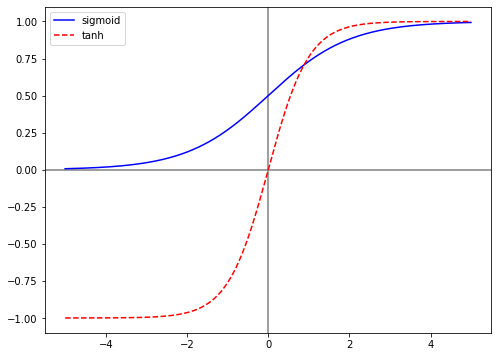

In [11]:
import math
 
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
 
x = np.arange(-5, 5, 0.01)
sigmoid_x = [sigmoid(z) for z in x]
tanh_x = [math.tanh(z) for z in x]
 
plt.figure(figsize=(8, 6))
 
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.plot(x, sigmoid_x, 'b-', label='sigmoid')
plt.plot(x, tanh_x, 'r--', label='tanh')
 
plt.legend()
plt.show()

## 딥러닝 모델  

- **중간층**  

  - 뉴런 6개

- **출력층**  

  - 뉴런 1개

```py
# 4.7 딥러닝 네트워크를 이용한 회귀
import tensorflow as tf
import numpy as np

# 인구증가율과 고령인구비율
X = [0.3, -0.78, 1.26, 0.03, 1.11, 0.24, -0.24, -0.47, -0.77, -0.37, -0.85, -0.41, -0.27, 0.02, -0.76, 2.66]
Y = [12.27, 14.44, 11.87, 18.75, 17.52, 16.37, 19.78, 19.51, 12.65, 14.74, 10.72, 21.94, 12.83, 15.51, 17.14, 14.42]

model = tf.keras.Sequential([
  tf.keras.layers.Dense(units=6, activation='tanh',  input_shape=(1,)),
  tf.keras.layers.Dense(units=1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.1), loss='mse')
model.summary()
```

## 학습

```py
# 딥러닝 네트워크의 학습
model.fit(X, Y, epochs=10)
```

In [14]:
# 인구증가율과 고령인구비율
X = [0.3, -0.78, 1.26, 0.03, 1.11, 0.24, -0.24, -0.47, -0.77, -0.37, -0.85, -0.41, -0.27, 0.02, -0.76, 2.66]
Y = [12.27, 14.44, 11.87, 18.75, 17.52, 16.37, 19.78, 19.51, 12.65, 14.74, 10.72, 21.94, 12.83, 15.51, 17.14, 14.42]

model = tf.keras.Sequential([
  tf.keras.layers.Dense(units=6, activation='tanh',  input_shape=(1,)),
  tf.keras.layers.Dense(units=1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.1), loss='mse')
model.summary()

model.fit(X, Y, epochs=10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1/1 [==============================] - 0s 1ms/step - loss: 253.1820
Epoch 2/10
1/1 [==============================] - 0s 1ms/step - loss: 102.8019
Epoch 3/10
1/1 [==============================] - 0s 956us/step - loss: 10.1356
Epoch 4/10
1/1 [==============================] - 0s 998us/step - loss: 9.7165
Epoch 5/10
1/1 [==============================] - 0s 998us/step - loss: 9.6649
Epoch 6/10
1/1 [==============================] - 0s 1ms/step - loss: 9.6485
Epoch 7/10
1/1 [==============================] -

## 예측

```py
# 딥러닝 네트워크의 Y값 예측
model.predict(X)
```

In [15]:
# 딥러닝 네트워크의 Y값 예측
model.predict(X)

array([[15.834511 ],
       [15.741853 ],
       [15.499983 ],
       [15.847639 ],
       [15.588923 ],
       [15.839885 ],
       [15.834695 ],
       [15.805463 ],
       [15.744321 ],
       [15.820125 ],
       [15.7238   ],
       [15.814614 ],
       [15.831794 ],
       [15.847602 ],
       [15.746763 ],
       [13.8767805]], dtype=float32)

## 결과 시각화

```py
# 딥러닝 네트워크의 회귀선 확인
import matplotlib.pyplot as plt

line_x = np.arange(min(X), max(X), 0.01)
line_y = model.predict(line_x)

plt.plot(line_x, line_y, 'r-')
plt.plot(X, Y, 'bo')

plt.xlabel('Population Growth Rate (%)')
plt.ylabel('Population Growth Rate (%)')
plt.show()
```

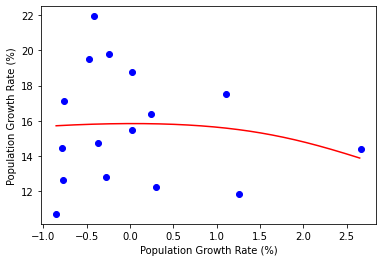

In [16]:
# 딥러닝 네트워크의 회귀선 확인
import matplotlib.pyplot as plt

line_x = np.arange(min(X), max(X), 0.01)
line_y = model.predict(line_x)

plt.plot(line_x, line_y, 'r-')
plt.plot(X, Y, 'bo')

plt.xlabel('Population Growth Rate (%)')
plt.ylabel('Population Growth Rate (%)')
plt.show()

# 시험문제

총 파라미터 (가중치 + 편향) 수는?



## 텐서플로만을 이용한 회귀 분석

- **optimizer**

  - 최적화 과정(복잡한 미분 계산 및 가중치 수정)을 자동으로 진행 ; SGD, adam

- **학습률(learning rate)**

  - 보통 0.1 ~ 0.0001  

```py
optimizer = tf.keras.optimizers.Adam(lr=0.07)
```


## 변수 Variables

- **딥러닝 학습에서 최적화 과정**  

  - 모델의 매개변수(parameters) 즉, 가중치(및 편향)를 조정하는 것

- **변수 tf.Variable**

  - 프로그램에 의해 변화하는 공유된 지속 상태를 표현하는 가장 좋은 방법  

    - 하나의 텐서를 표현
    - 텐서 값은 텐서에 연산을 수행하여 변경 가능

  - 모델 파라미터를 저장하는데 tf.Variable을 사용

- **변수 생성**

  - 변수를 생성하려면 단순하게 초기값을 설정

```py
# a와 b를 랜덤한 값으로 초기화
# a = tf.Variable(random.random())
# b = tf.Variable(random.random())
a = tf.Variable(tf.random.uniform([1], 0, 1))
b = tf.Variable(tf.random.uniform([1], 0, 1))
```

## 메소드 minimize()

- **첫 번째 인자**

  - 최소화할 손실 함수

- **두 번째 인자 var_list**

  - 학습시킬 변수 리스트, 가중치와 편향  

- **1000번의 학습을 거쳐**

  - 잔차의 제곱 평균을 최소화하는 적절한 값 a, b에 도달을 기대


```py
for i in range(1000):
  # 잔차의 제곱의 평균을 최소화(minimize) 합니다.
  optimizer.minimize(compute_loss, var_list=[a, b])
```

99 a:  [0.12862723]  b:  [6.5359507]  loss:  93.00569
199 a:  [-0.1111355]  b:  [11.057257]  loss:  31.002567
299 a:  [-0.25234342]  b:  [13.718689]  loss:  13.57693
399 a:  [-0.31968674]  b:  [14.988002]  loss:  10.243917
499 a:  [-0.34545976]  b:  [15.473768]  loss:  9.818954
599 a:  [-0.35339743]  b:  [15.623385]  loss:  9.7829075
699 a:  [-0.3553688]  b:  [15.660548]  loss:  9.780881
799 a:  [-0.35576192]  b:  [15.667973]  loss:  9.780806
899 a:  [-0.35582444]  b:  [15.669155]  loss:  9.780804
999 a:  [-0.35583338]  b:  [15.669302]  loss:  9.780804


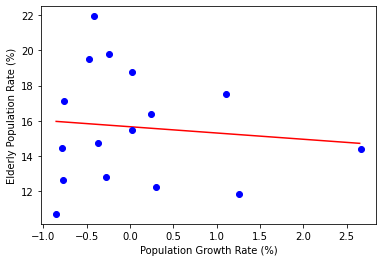

In [18]:
## 텐서플로만을 이용한 회귀 분석 소스

X = [0.3, -0.78, 1.26, 0.03, 1.11, 0.24, -0.24, -0.47, -0.77, -0.37, -0.85, -0.41, -0.27, 0.02, -0.76, 2.66]
Y = [12.27, 14.44, 11.87, 18.75, 17.52, 16.37, 19.78, 19.51, 12.65, 14.74, 10.72, 21.94, 12.83, 15.51, 17.14, 14.42]

# a와 b를 랜덤한 값으로 초기화
# a = tf.Variable(random.radonm())
# b = tf.Variable(random.radonm())
a = tf.Variable(tf.random.uniform([1], 0, 1))
b = tf.Variable(tf.random.uniform([1], 0, 1))

# 잔차의 제곱의 평균을 반환하는 함수
def compute_loss():
  y_pred = a * X + b
  loss = tf.reduce_mean((Y - y_pred) ** 2)
  return loss

optimizer = tf.keras.optimizers.Adam(lr=0.07)

for i in range(1000):
  # 잔차의 제곱의 평균을 최소화
  optimizer.minimize(compute_loss, var_list=[a, b])

  if i % 100 == 99:
    print(i, 'a: ', a.numpy(), ' b: ', b.numpy(), ' loss: ', compute_loss().numpy())

# 텐서플로만을 이용한 회귀 분석 회귀선 그리기

line_x = np.arange(min(X), max(X), 0.01)
line_y = a * line_x + b

# 그래프 그리기
plt.plot(line_x, line_y, 'r-')
plt.plot(X, Y, 'bo')
plt.xlabel('Population Growth Rate (%)')
plt.ylabel('Elderly Population Rate (%)')
plt.show()


# 보스톤 주택 가격 예측


## 주요 활성화 함수 

- **ReLU**
- **Sigmoid**
- **Tanh**

```py
# 활성화 함수
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))


x = np.arange(-5, 5, 0.01)
sigmoid_x = [sigmoid(z) for z in x]
tanh_x = [math.tanh(z) for z in x]
relu = [0 if z < 0 else z for z in x]

plt.figure(figsize=(8, 6))

plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.plot(x, sigmoid_x, 'b--', label='sigmoid')
plt.plot(x, tanh_x, 'r--', label='tanh')
plt.plot(x, relu, 'g.', labe='relu')
plt.legend()
plt.show()
```

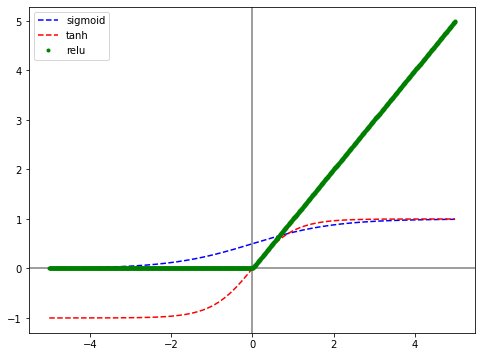

In [20]:
# 주요 활성화 함수

import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))


x = np.arange(-5, 5, 0.01)
sigmoid_x = [sigmoid(z) for z in x]
tanh_x = [math.tanh(z) for z in x]
relu = [0 if z < 0 else z for z in x]

plt.figure(figsize=(8, 6))

plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.plot(x, sigmoid_x, 'b--', label='sigmoid')
plt.plot(x, tanh_x, 'r--', label='tanh')
plt.plot(x, relu, 'g.', label='relu')
plt.legend()
plt.show()

## 보스톤 주택 가격 예측

- **1978년 보스톤 지역 주택 가격 데이터 셋**

  - 506개 타운의 주택 가격 중앙 값, 천 달러 단위
  - 범죄율, 방 수, 고속도로 까지 거리 등 13가지 특성, p93  
  - 학습 데이터 ; 404개
  - 테스트 데이터 ; 102개

  ```py
  # 데이터 불러오기
  from tensorflow.keras.datasets import boston_housing

  (train_X, train_Y), (test_X, test_Y) = boston_housing.load_data()

  print(train_X.shape, test_X.shape)
  print(train_X[0])
  print(train_Y[0])   # 15.2 천 달러
  ```

In [21]:
# 보스톤 주택 가격 예측

from tensorflow.keras.datasets import boston_housing

(train_X, train_Y), (test_X, test_Y) = boston_housing.load_data()

print(train_X.shape, test_X.shape)
print(train_X[0])
print(train_Y[0])

57344/57026 [==============================] - 0s 0us/step
(404, 13) (102, 13)
[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
15.2


## 자료의 정규화 

- **정규화의 필요**

  - 특성의 단위가 다르므로 ; 비율, 0/1, 양수 등
  - 정규화가 학습 효율에 좋음

- **정규화 방법**

  - 학습 데이터 : (train_X - 학습 데이터 평균) / 학습 데이터 표준편차 

    - 정규 분포를 가정

  - 테스트 데이터 : (test_X - 학습 데이터 평균) / 학습 데이터 표준편차  

    - 테스트데이터가 정규 분포를 가정할 수 없으므로 테스트 데이터 평균이 아닌 학습 데이터 평균을 사용  

```py
# 데이터 전처리(정규화)
x_mean = train_X.mean(axis=0)
x_std = train_X.std(axis=0)

train_X -= x_mean
train_X /= x_std

test_X -= x_mean
test_X /= x_std

y_mean = train_Y.mean(axis=0)
y_std = train_Y.std(axis=0)

train_Y -= y_mean
train_Y /= y_std

test_Y -= y_mean
test_Y /= y_std
print(train_X[0])
print(train_Y[0])

```

In [22]:
# 자료의 정규화


# 데이터 전처리
x_mean = train_X.mean(axis=0)
x_std = train_X.std(axis=0)

train_X -= x_mean
train_X /= x_std

test_X -= x_mean
test_X /= x_std

y_mean = train_Y.mean(axis=0)
y_std = train_Y.std(axis=0)

train_Y -= y_mean
train_Y /= y_std

test_Y -= y_mean
test_Y /= y_std

print(train_X[0])
print(train_Y[0])


[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
  0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
  0.8252202 ]
-0.7821526033779157


## 딥러닝 모델 

- **4개의 층**

  - 출력 층은 회귀 모델, 주택 가격이므로 1

- **최적화**

  - 학습률 ; lr=0.07

  - 손실 함수 ; mse

```py
# Boston Housing Dataset 회귀 모델 생성
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(units=52, activation='relu', input_shape=(13,)),
  tf.keras.layers.Dense(units=39, activation='relu'),
  tf.keras.layers.Dense(units=26, activation='relu'),
  tf.keras.layers.Dense(units=1)
])

model.complie(optimizer=tf.keras.optimizers.Adam(lr=0.07), loss='mse')

model.summary()
```

In [24]:
## 딥러닝 모델

# Boston Housing Dataset 회귀 모델 생성
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(units=52, activation='relu', input_shape=(13,)),
  tf.keras.layers.Dense(units=39, activation='relu'),
  tf.keras.layers.Dense(units=26, activation='relu'),
  tf.keras.layers.Dense(units=1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.07), loss='mse')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 52)                728       
_________________________________________________________________
dense_7 (Dense)              (None, 39)                2067      
_________________________________________________________________
dense_8 (Dense)              (None, 26)                1040      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 27        
Total params: 3,862
Trainable params: 3,862
Non-trainable params: 0
_________________________________________________________________


## 학습

- **배치 사이즈와 검증 데이터**

  - 훈련과 검증 분리, 훈련 데이터 404개 중 일부를 검증 데이터로 사용  

    - Validation_split:

      - 검증용 데이터의 비율

    - 만일 .2면

      - 훈련:검증 == 80%:20% 비중으로 준비  

  - Batch_size

    - 훈련에서 가중치와 편향의 파라미터를 수정하는 데이터 단위 수 

  - train_size
    
    - 훈련 데이터 수

```py
# 회귀 모델 학습
History = model.fit(train_X, train_Y, epochs=25, batch_size=32, validation_split=0.25)
```

In [29]:
## 학습

# 회귀 모델 학습
History = model.fit(train_X, train_Y, epochs=25, batch_size=32, validation_split=0.25)

Epoch 1/25
10/10 [==============================] - 0s 4ms/step - loss: 0.0508 - val_loss: 0.1332
Epoch 2/25
10/10 [==============================] - 0s 4ms/step - loss: 0.0443 - val_loss: 0.1025
Epoch 3/25
10/10 [==============================] - 0s 4ms/step - loss: 0.0585 - val_loss: 0.2160
Epoch 4/25
10/10 [==============================] - 0s 4ms/step - loss: 0.0812 - val_loss: 0.1185
Epoch 5/25
10/10 [==============================] - 0s 4ms/step - loss: 0.0527 - val_loss: 0.1043
Epoch 6/25
10/10 [==============================] - 0s 4ms/step - loss: 0.0491 - val_loss: 0.1073
Epoch 7/25
10/10 [==============================] - 0s 5ms/step - loss: 0.0385 - val_loss: 0.1057
Epoch 8/25
10/10 [==============================] - 0s 4ms/step - loss: 0.0360 - val_loss: 0.1101
Epoch 9/25
10/10 [==============================] - 0s 5ms/step - loss: 0.0427 - val_loss: 0.1099
Epoch 10/25
10/10 [==============================] - 0s 28ms/step - loss: 0.0397 - val_loss: 0.1191
Epoch 11/25
10/10 

## 훈련과정 시각화와 평가  

- **검증 데이터 손실**

  - 일반적으로 loss는 꾸준히 감소

  - val_loss

    - 일반적으로 loss보다 높음
    - 항상 감소하지도 않음

- **평가 결과**

  - 손실값

    - 작을수록 좋은 결과
    - 검증 손실이 적을수록 테스트 평가의 손실도 적음

```py
# 회귀 모델 학습 결과 시각화
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()


# 회귀 모델 평가
model.evaluate(test_X, test_Y)
```

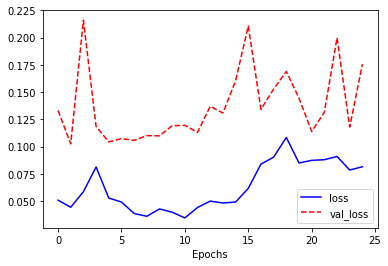

In [31]:
## 훈련 과정 시각화와 평가

# 회귀 모델 학습 결과 시각화
plt.plot(History.history['loss'], 'b-', label='loss')
plt.plot(History.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [32]:
# 회귀 모델 평가
model.evaluate(test_X, test_Y)

4/4 [==============================] - 0s 2ms/step - loss: 0.1755


0.17545266449451447

## 예측 시각화

- **테스트 데이터의 예측과 실제 주택 가격 비교**

  - 각 점들이 점선의 대각선에 있어야 좋은 예측

```py
# 실제 주택 가격과 예측 주택 가격 시각화
import matplotlib.pyplot as plt

pred_y = model.predict(test_X)

plt.figure(figsize=(8, 8))
plt.plot(test_Y, pred_Y, 'b.')
plt.axis([min(test_Y), max(test_Y), min(test_Y), max(test_Y)])

# y = x에 해당하는 대각성
plt.plot([min(test_Y), max(test_Y)], [min(test_Y), max(test_Y)], ls='--', c=".5")
plt.xlabel('test_Y')
plt.ylabel('pred_Y')

plt.show()
```

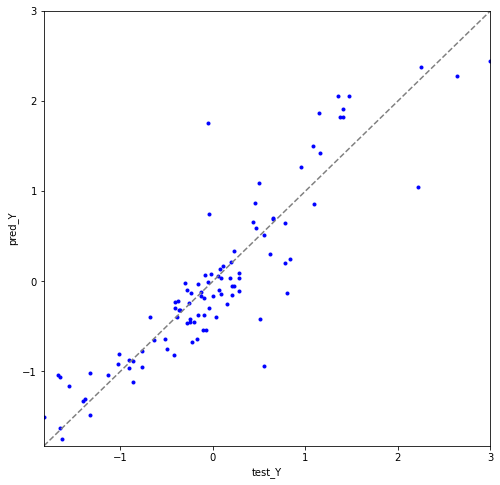

In [35]:
## 예측 시각화

# 실제 주택 가격과 예측 주택 가격 시각화
pred_Y = model.predict(test_X)

plt.figure(figsize=(8, 8))
plt.plot(test_Y, pred_Y, 'b.')
plt.axis([min(test_Y), max(test_Y), min(test_Y), max(test_Y)])

# y = x에 해당하는 대각성
plt.plot([min(test_Y), max(test_Y)], [min(test_Y), max(test_Y)], ls='--', c=".5")
plt.xlabel('test_Y')
plt.ylabel('pred_Y')

plt.show()

## 자동으로 학습 중단

- **검증 손실(val_loss)이 적을 수록 테스트 평가의 손실도 적음**

- **검증 데이터에 대한 성적이 좋도록 유도**

  - 과적합에 의해 검증 손실이 증가하면 학습을 중단되도록 지정  

  - 함수 Callbacks 사용

  ```py
  history = model.fit(train_X, train_Y, epochs=25, batch_size=32, validation_split=0.25, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')])
  ```

- **일찍 멈춤 기능**

  - tf.keras.callbacks.EarlyStopping

    - monitor = 'val_loss'

      - 지켜볼 기준 값이 검증 손실

    - patience = 3

      - 3회의 epochs를 실행하는 동안 기준 값이 최고 기록을 갱신하지 못하면(더 낮아지지 않으면) 학습을 멈춤

## EarlyStopping

- **10 에폭의 기록인 .1748 이후**

  - 13 에폭에서도 그 기록을 갱신하지 못했으므로 학습을 중단

```py
history = model.fit(train_X, train_Y, epochs=25, batch_size=32, validation_split=0.25, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')])
```

Epoch 1/25
10/10 [==============================] - 0s 5ms/step - loss: 0.0366 - val_loss: 0.1541
Epoch 2/25
10/10 [==============================] - 0s 5ms/step - loss: 0.0437 - val_loss: 0.1562
Epoch 3/25
10/10 [==============================] - 0s 4ms/step - loss: 0.0505 - val_loss: 0.2038
Epoch 4/25
10/10 [==============================] - 0s 4ms/step - loss: 0.0560 - val_loss: 0.1383
Epoch 5/25
10/10 [==============================] - 0s 4ms/step - loss: 0.0727 - val_loss: 0.1040
Epoch 6/25
10/10 [==============================] - 0s 4ms/step - loss: 0.0389 - val_loss: 0.1131
Epoch 7/25
10/10 [==============================] - 0s 4ms/step - loss: 0.0436 - val_loss: 0.1321
Epoch 8/25
10/10 [==============================] - 0s 4ms/step - loss: 0.0641 - val_loss: 0.1478


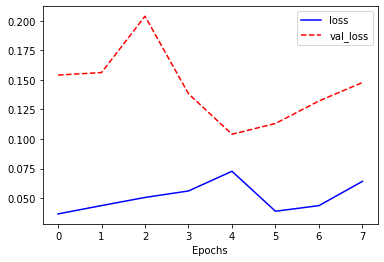

In [46]:
## 자동 중단 시각화

# 회귀 모델 학습 결과 시각화

history = model.fit(train_X, train_Y, epochs=25, batch_size=32, validation_split=0.25, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')])

plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [42]:
## 자동 중단 시각화

# 회귀 모델 평가

model.evaluate(test_X, test_Y)

4/4 [==============================] - 0s 1ms/step - loss: 0.2243


0.2243194580078125

In [47]:
## Dropout

# 모델 재정의 및 학습, dropout 사용

model = tf.keras.Sequential([
                             tf.keras.layers.Dense(units=52, activation='relu', input_shape=(13,)),
                             tf.keras.layers.Dense(units=39, activation='relu'),
                             tf.keras.layers.Dense(units=26, activation='relu'),
                             tf.keras.layers.Dropout(.1),
                             tf.keras.layers.Dense(units=1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.07), loss='mse')

history = model.fit(train_X, train_Y, epochs=25, batch_size=32, validation_split=0.25, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')])

Epoch 1/25
10/10 [==============================] - 0s 10ms/step - loss: 2.4109 - val_loss: 1.0888
Epoch 2/25
10/10 [==============================] - 0s 4ms/step - loss: 0.5674 - val_loss: 0.7253
Epoch 3/25
10/10 [==============================] - 0s 6ms/step - loss: 0.5137 - val_loss: 0.3457
Epoch 4/25
10/10 [==============================] - 0s 4ms/step - loss: 0.3458 - val_loss: 0.2450
Epoch 5/25
10/10 [==============================] - 0s 5ms/step - loss: 0.2580 - val_loss: 0.2334
Epoch 6/25
10/10 [==============================] - 0s 4ms/step - loss: 0.2327 - val_loss: 0.1731
Epoch 7/25
10/10 [==============================] - 0s 4ms/step - loss: 0.2237 - val_loss: 0.2245
Epoch 8/25
10/10 [==============================] - 0s 4ms/step - loss: 0.2346 - val_loss: 0.3133
Epoch 9/25
10/10 [==============================] - 0s 4ms/step - loss: 0.2525 - val_loss: 0.2099


밑으로는 예측 시각화.. 학습 시각화 반복

# 자동차 연비 (auto mpg: mile per gallon) 데이터로 회귀분석 

## 회귀와 분류  

- **회귀(regression)**

  - 가격이나 확률 같이 연속된 출력 값을 예측하는 것이 목적  

- **분류(classification)**

  - 여러 개의 클래스 중 하나의 클래스를 선택하는 것이 목적

  - 예를 들어, 사진에 사과 또는 오렌지가 포함되어 있을 때 어떤 과일인지 인식하는 것  

- **자동차 연비를 예측하는 모델**

  - Auto MPG 데이터 셋을 사용  
  - 1970년대 후반과 1980년대 초반의 데이터
  - 이 기간에 출시된 자동차 정보를 모델에 제공
    - 실린더 수, 배기량, 마력, 공차 증량 같은 속성
  - 이 예제는 tf.keras API를 사용

- **MPG**

  - Mile per gallon
  - 연비
  - km/l

## seaborn 설치와 모듈 가져오기

- **seaborn 설치**

  - !pip install seaborn
  - !pip install -q seaborn  ; 메시지 출력 최소화
  - pip install seaborn

- **모듈 가져오기**

  ```py
  import pandas as pd
  import seaborn as sns
  import matplotlib.pyplot as plt

  import tensorflow as tf
  from tensorflow import keras
  from tensorflow.keras import layers
  ```

## Auto MPG 데이터 셋

- **UCI 머신 러닝 저장소에서 다운로드**

```py
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

print(dataset_path)
```

- **판다스를 사용하여 데이터를 읽기**

```py
col_names= ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

row_data = pd.read_csv(dataset_path, names=col_names, na_values="?", comment='\t', sep=" ", skipinitialspace=True)

dataset = raw_data.copy()
dataset.tail(10)
```



In [49]:
!pip install -q seaborn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [62]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

print(dataset_path)

# 데이터를 읽어 dataset에 저장
col_names= ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

raw_data = pd.read_csv(dataset_path, names=col_names, na_values="?", comment='\t', sep=" ", skipinitialspace=True)

dataset = raw_data.copy()
dataset.tail(10)

/root/.keras/datasets/auto-mpg.data


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
388,26.0,4,156.0,92.0,2585.0,14.5,82,1
389,22.0,6,232.0,112.0,2835.0,14.7,82,1
390,32.0,4,144.0,96.0,2665.0,13.9,82,3
391,36.0,4,135.0,84.0,2370.0,13.0,82,1
392,27.0,4,151.0,90.0,2950.0,17.3,82,1
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [52]:
dataset.head(10)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
5,15.0,8,429.0,198.0,4341.0,10.0,70,1
6,14.0,8,454.0,220.0,4354.0,9.0,70,1
7,14.0,8,440.0,215.0,4312.0,8.5,70,1
8,14.0,8,455.0,225.0,4425.0,10.0,70,1
9,15.0,8,390.0,190.0,3850.0,8.5,70,1


In [65]:
## 데이터 정제

# 데이터 정제 - 비어있는 칼럼의 행의 수 알아내기
cnt = dataset.isna().sum()
print(cnt)

# 비어있는 행 제거
dataset = dataset.dropna()

# 열 'Origin'을 빼내 origin에 저장
origin = dataset.pop('Origin')
print(origin)

# 'Origin'열은 수치형이 아니고 범주형이므로 원-핫 인코딩으로 변환
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail(10)

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64
0      1
1      1
2      1
3      1
4      1
      ..
393    1
394    2
395    1
396    1
397    1
Name: Origin, Length: 392, dtype: int64


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
388,26.0,4,156.0,92.0,2585.0,14.5,82,1.0,0.0,0.0
389,22.0,6,232.0,112.0,2835.0,14.7,82,1.0,0.0,0.0
390,32.0,4,144.0,96.0,2665.0,13.9,82,0.0,0.0,1.0
391,36.0,4,135.0,84.0,2370.0,13.0,82,1.0,0.0,0.0
392,27.0,4,151.0,90.0,2950.0,17.3,82,1.0,0.0,0.0
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## 데이터셋을 훈련 셋트와 테스트 셋트로 분할

- **80:20으로**

  - 테스트 셋트는 모델을 최종적으로 평가할 때 사용

```py
# 데이터셋을 훈련 세트와 테스트 세트로 분할
# 전체 자료에서 80%를 훈련 데이터로 사용
train_dataset = dataset.sample(frac=0.8, random_state=0)
print(train_dataset)

# 전체 자료에서 나머지 20%를 테스트 데이터로 사용
test_dataset = dataset.drop(train_dataset.index)
print(test_dataset)
```

In [66]:
# 데이터셋을 훈련 세트와 테스트 세트로 분할
# 전체 자료에서 80%를 훈련 데이터로 사용
train_dataset = dataset.sample(frac=0.8, random_state=0)
print(train_dataset)

# 전체 자료에서 나머지 20%를 테스트 데이터로 사용
test_dataset = dataset.drop(train_dataset.index)
print(test_dataset)

      MPG  Cylinders  Displacement  Horsepower  ...  Model Year  USA  Europe  Japan
146  28.0          4          90.0        75.0  ...          74  1.0     0.0    0.0
282  22.3          4         140.0        88.0  ...          79  1.0     0.0    0.0
69   12.0          8         350.0       160.0  ...          72  1.0     0.0    0.0
378  38.0          4         105.0        63.0  ...          82  1.0     0.0    0.0
331  33.8          4          97.0        67.0  ...          80  0.0     0.0    1.0
..    ...        ...           ...         ...  ...         ...  ...     ...    ...
281  19.8          6         200.0        85.0  ...          79  1.0     0.0    0.0
229  16.0          8         400.0       180.0  ...          77  1.0     0.0    0.0
150  26.0          4         108.0        93.0  ...          74  0.0     0.0    1.0
145  32.0          4          83.0        61.0  ...          74  0.0     0.0    1.0
182  28.0          4         107.0        86.0  ...          76  0.0     1.0

## 시본의 산점도

- **대각선 diag_kind**

  - 커널밀도추정곡선
  - kde ; Kernal Density Estimation

- **색상**

  - palette='bright'

    - pastel, bright, deep, muted, colorblind, dark

```py
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")
```

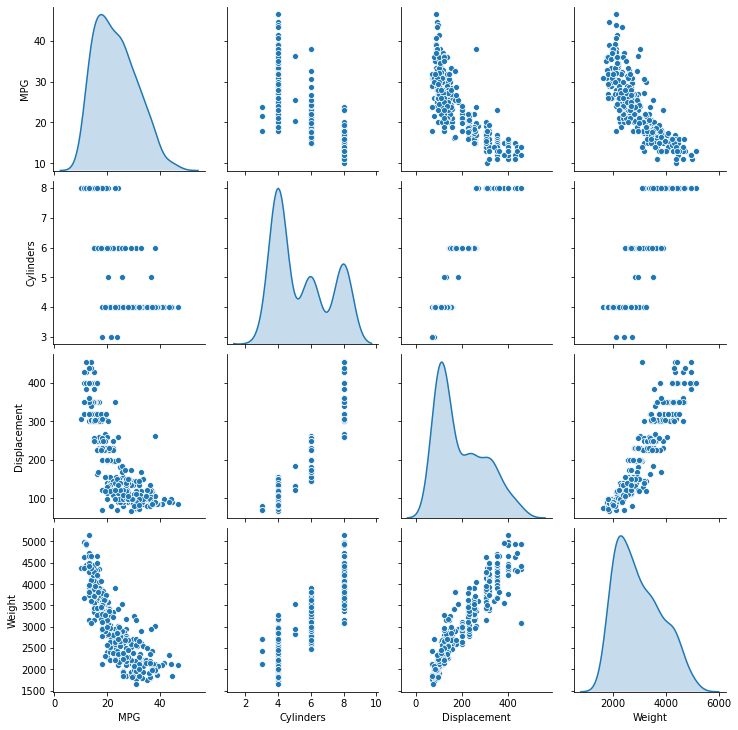

In [55]:
## 시본의 산점도

sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

## 전반적인 통계 확인

- **describe()**

```py
# 전반적인 통계 확인
train_stats = train_dataset.describe()
print(train_stats)


train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats.head(9)
```

In [57]:
# 전반적인 통계 확인

train_stats = train_dataset.describe()

print(train_stats)

train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats.head(9)

              MPG   Cylinders  Displacement  ...         USA      Europe       Japan
count  314.000000  314.000000    314.000000  ...  314.000000  314.000000  314.000000
mean    23.310510    5.477707    195.318471  ...    0.624204    0.178344    0.197452
std      7.728652    1.699788    104.331589  ...    0.485101    0.383413    0.398712
min     10.000000    3.000000     68.000000  ...    0.000000    0.000000    0.000000
25%     17.000000    4.000000    105.500000  ...    0.000000    0.000000    0.000000
50%     22.000000    4.000000    151.000000  ...    1.000000    0.000000    0.000000
75%     28.950000    8.000000    265.750000  ...    1.000000    0.000000    0.000000
max     46.600000    8.000000    455.000000  ...    1.000000    1.000000    1.000000

[8 rows x 10 columns]


,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


## 데이터 정규화  

- **특성의 스케일과 범위가 다르면 정규화(nomalization)하는 것을 권장**

  - 의도적으로 훈련 세트만 사용하여 통계치를 생성

    - 테스트 세트를 정규화할 때에도 사용 ; 테스트 세트를 모델이 훈련에 사용했던 것과 동일한 분포로 투영하기 위해서

- **정규화된 데이터를 사용하여 모델을 훈련**

  - 입력 데이터를 정규화하기 위해 사용한 통계치(평균과 표준편차)는 원-핫 인코딩과 마찬가지로 모델에 주입되는 모든 데이터에 적용 

```py
train_labels = train_dataset.pop('MPG')
test_labels = test_database.pop('MPG')

# 정규화
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']


normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_train_data.tail(10)
```

In [68]:
## 데이터 정규화
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

# 정규화
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']


normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_train_data.tail(10)

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
171,-0.869348,-0.587727,-0.232816,-0.341571,-0.738281,-0.244335,-1.286751,-0.465148,2.012852
70,1.483887,1.961837,2.234620,1.696588,-1.096803,-1.060519,0.774676,-0.465148,-0.495225
307,0.307270,-0.213919,0.265921,-0.343941,-0.953394,0.843910,0.774676,-0.465148,-0.495225
49,-0.869348,-0.702745,-0.495310,-0.912730,-0.559020,-1.332580,0.774676,-0.465148,-0.495225
209,-0.869348,-0.721914,-0.442811,0.331495,2.273303,0.027726,-1.286751,2.143005,-0.495225
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,0.774676,-0.465148,-0.495225
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,0.774676,-0.465148,-0.495225
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,-1.286751,-0.465148,2.012852
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,-1.286751,-0.465148,2.012852
182,-0.869348,-0.846517,-0.495310,-0.623596,-0.021237,0.027726,-1.286751,2.143005,-0.495225


## 모델을 구성

- **두 개의 완전 연결(densely connected) 은닉층으로 Sequential 모델**

  - 출력 층은 하나의 연속적인 값을 반환
  - 나중에 두 번째 모델을 만들기 쉽도록 build_model 함수로 모델 구성 단계를 감싼다  

```py
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

  return model

model = build_model()
model.summary()
```

In [69]:
## 모델을 구성

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

  return model

model = build_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


## 옵티마이저 발전 과정

pdf 참고

[pdf바로가기](https://github.com/lee7py/Tensorflow-DNN/blob/master/%5B04-2%20%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%20%EA%B8%B0%EB%B0%98%20%EB%94%A5%EB%9F%AC%EB%8B%9D%5D%20(0724%EA%B8%88%203~4%EA%B5%90%EC%8B%9C%20p21%20%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9C%BC%EB%A1%9C%20%EC%98%88%EC%B8%A1%ED%95%98%EB%8A%94%20%EC%9E%90%EB%8F%99%EC%B0%A8%20%EC%97%B0%EB%B9%84.pdf)

## 모델을 한번 실행 

- **훈련 세트에서 10 샘플을 하나의 배치로 만들어**  

  - model.predict 메소드를 호출

```py
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
print(example_result)
```

In [71]:
## 모델을 한번 실행  

example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
print(example_result)

[[ 0.07276892]
 [-0.00657997]
 [ 0.23127897]
 [-0.00578417]
 [-0.11937727]
 [ 0.03421593]
 [-0.15766212]
 [-0.01199109]
 [ 0.10231946]
 [-0.22247072]]


## 모델 훈련 

- **1,000번의 에포크(epoch) 동안 훈련**

  - 훈련 정확도와 검증 정확도는 history 객체에 기록

```py
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000
history = model.fit(normed_train_data, train_labels, epochs = EPOCHS, validation_split = 0.2, verbose = 0, callbacks = [PrintDot()])
```

In [72]:
## 모델 훈련

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')
 
EPOCHS = 1000
history = model.fit(normed_train_data, train_labels, epochs = EPOCHS, validation_split = 0.2, verbose = 0, callbacks = [PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

## 콜백

- **학습 과정의 한 에폭마다 적용할 함수의 셋트**  

  - 학습의 각 단계에서 콜백의 적절한 메소드가 호출
  - 모델의 내적 상태와 통계자료를 확인
  - 키워드 인수 callbacks
    - Sequential이나 Model 클래스의 .fit() 메소드에 전달이 가능  

```py
# 에포크가 끝날 때마다 점(.)을 출력, 100번마다 다음 줄로 이동해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])
```

## history 객체에 저장된 통계치를 사용

```py
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(10)
```

In [73]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(10)     # loss / mae /mse : 훈련데이터
                  # val_loss / val_mae / val_mse : 검증 데이터

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
990,2.577888,1.042659,2.577888,9.026702,2.359331,9.026702,990
991,2.412660,1.002907,2.412660,8.750994,2.312143,8.750994,991
992,2.490566,1.021275,2.490566,8.856827,2.292613,8.856827,992
993,2.497655,1.033815,2.497655,9.301029,2.410749,9.301029,993
994,2.568465,1.043734,2.568465,8.629151,2.289115,8.629151,994
995,2.471673,0.990121,2.471673,8.836697,2.357147,8.836697,995
996,2.449622,1.004168,2.449622,9.983235,2.474280,9.983235,996
997,2.560929,1.032484,2.560929,9.293814,2.410289,9.293814,997
998,2.533605,1.022331,2.533605,8.516132,2.224422,8.516132,998
999,2.580787,1.011679,2.580787,8.233750,2.219776,8.233750,999


## 훈련 과정을 시각화  

- **검증 손실이 계속 감소하는 것이 중요**

```py
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  plt.figure(figsize=(8, 12))

  plt.subplot(2, 1, 1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
  plt.ylim([0, 5])
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
  plt.ylim([0, 20])
  plt.legend()
  plt.show()

plot_history(history)
```

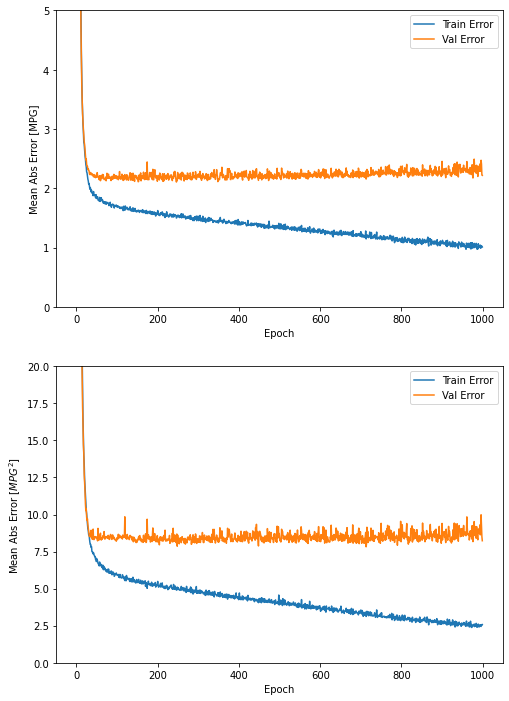

In [74]:
## 훈련 과정을 시각화

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  plt.figure(figsize=(8, 12))

  plt.subplot(2, 1, 1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
  plt.ylim([0, 5])
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
  plt.ylim([0, 20])
  plt.legend()
  plt.show()

plot_history(history)

## EarlyStopping 콜백

- **EarlyStopping 콜백(callback)**

  - model.fit 메소드를 수정하여 검증 점수가 향상되지 않으면 자동으로 훈련을 멈추도록

    - 지정된 에포크 훈련 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈추도록 한다.
    - 옵션 monitor, patience
      - 손실 val_loss가 10회 초과해 감소하지 않으면 중단

  
```py
model = build_model()


early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split=0.2,verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)
```

## 모델의 성능을 확인

- **테스트 세트에서 모델의 성능을 확인**  

```py
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("테스트 세트의 평균 절대 오차:[:5.2f] MPG".format(mae))
```

In [75]:
## 모델의 성능을 확인

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("테스트 세트의 평균 절대 오차:[:5.2f] MPG".format(mae))

3/3 - 0s - loss: 6.5579 - mae: 2.0015 - mse: 6.5579
테스트 세트의 평균 절대 오차:[:5.2f] MPG


## 예측(1)

- **테스트 세트에 있는 샘플을 사용해 MPG 값을 예측**

```py
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
```

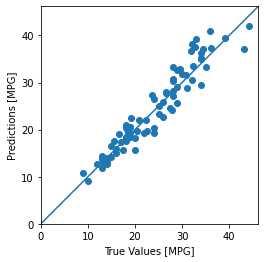

In [77]:
## 예측 (1)

test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

## 메소드 axis()

pdf 참고..

[pdf바로가기](https://github.com/lee7py/Tensorflow-DNN/blob/master/%5B04-2%20%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%20%EA%B8%B0%EB%B0%98%20%EB%94%A5%EB%9F%AC%EB%8B%9D%5D%20(0724%EA%B8%88%203~4%EA%B5%90%EC%8B%9C%20p21%20%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9C%BC%EB%A1%9C%20%EC%98%88%EC%B8%A1%ED%95%98%EB%8A%94%20%EC%9E%90%EB%8F%99%EC%B0%A8%20%EC%97%B0%EB%B9%84.pdf)

## 예측 (2)

- **오차의 분포**  

```py
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")
```

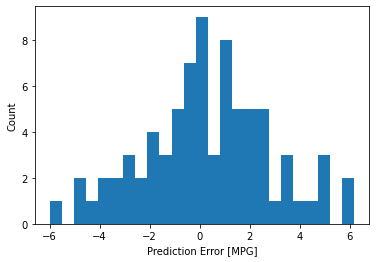

In [78]:
## 예측 (2)

error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

# 이항 분류 및 다항 분류


## 이진(이항) 분류

- **두 가지로 분류하는 방법**

  - PASS / FAIL
  - SPAM / HAM
  - 긍정 positive와 부정 negative ; 리뷰 텍스트를 기반으로 영화 리뷰
  - 로지스틱 회귀라고도 부름  

- **결과 기술 방식** 

  - 4개의 결과

    - 일반 레이블 방식 ; [0, 1, 0, 1]
    - One Hot Encoding 방식 ; [[1, 0], [0, 1], [1, 0], [0, 1]]

## 이진 분류 개념  

[pdf 참고 바로가기](file:///C:/Users/315/workspace/2020tech/deep_learning/pdf/200724/[04-3%20%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%20%EA%B8%B0%EB%B0%98%20%EB%94%A5%EB%9F%AC%EB%8B%9D]%20(0724%EA%B8%88%205~6%EA%B5%90%EC%8B%9C%20p20%20%EB%B6%84%EB%A5%98%20%EA%B0%9C%EC%9A%94%EC%99%80%20%EC%9D%B4%ED%95%B4.pdf) - 4 페이지

## 이진 분류 활성화 함수

[pdf 참고 바로가기](file:///C:/Users/315/workspace/2020tech/deep_learning/pdf/200724/[04-3%20%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%20%EA%B8%B0%EB%B0%98%20%EB%94%A5%EB%9F%AC%EB%8B%9D]%20(0724%EA%B8%88%205~6%EA%B5%90%EC%8B%9C%20p20%20%EB%B6%84%EB%A5%98%20%EA%B0%9C%EC%9A%94%EC%99%80%20%EC%9D%B4%ED%95%B4.pdf) - 5 페이지

## 시그모이드 함수  

- **이진분류 모델의 출력층에 주로 사용되는 활성화 함수**

  - 0과 1사이의 값으로 출력  

  - 출력 값이 특정 임계값 (예를 들어 0.5) 이상이면 양성

    - 이하이면 음성이라고 판별  ; f(x) = 1 / (1 + e^(-x))


```py
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, 100)
y = 1 / (1 + np.exp(-x))
plt.plot(x, y)
plt.show()
```

## 이진 분류와 다중 분류  

- **시그모이드 함수와 소프트맥스 함수**

[pdf 참고 바로가기](file:///C:/Users/315/workspace/2020tech/deep_learning/pdf/200724/[04-3%20%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%20%EA%B8%B0%EB%B0%98%20%EB%94%A5%EB%9F%AC%EB%8B%9D]%20(0724%EA%B8%88%205~6%EA%B5%90%EC%8B%9C%20p20%20%EB%B6%84%EB%A5%98%20%EA%B0%9C%EC%9A%94%EC%99%80%20%EC%9D%B4%ED%95%B4.pdf) - 7 페이지


> 마지막 0.01 / 0.14 / 0.85 는 확률. 다 더하면 1


## 소프트맥스 함수

- **분류의 마지막 활성화 함수로 사용**  

  - 모든 yi의 합은 1

    - 각각의 yi는 그 분류의 확률

- **뉴런의 결과를 e의 지수승으로 하여 모든 합으로 나눈 결과**  

  - exp(x) / tf.reduce_sum(exp(x))



> softmax 함수에 대해서는 교재 p.117 참고

## 대표적 다중 분류  

- **MNIST 손글씨**

## 분류에서의 손실 함수  

- **크로스 엔트로피**  

  - 실제 데이터의 결과 값인 y

    - y = 1 일 때

      - 예측 값이 1에 가까워질수록 cost function의 값은 작아져야 한다.
      - 반대로 0에 가까워질수록 cost function의 값이 무한대로 증가하게 되어 예측이 틀렸다는 것을 보여주어야 함

    - y = 0 일 때

      - 예측이 0으로 맞게 되면 cost function은 매우 작은 값을 가지고  
      - 반대로 예측이 1로 하게 되어 예측에 실패할 경우 cost 값이 무한대로 증가하여 틀렸다는 것을 알 수 있게 해야 함

## 크포스 엔트로피 손실 함수 직접 그리기

- **Cross entropy**

```py
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.1e - 1
x = np.linspace(0 + alpha, 1 - alpha, 100)
y1 = -np.log(x)
y2 = -np.log(1-x)

plt.axhline(y=0, color="r", linestyle="--", linewidth=1)
plt.axvline(x=1, color="r", linestyle="-.", linewidth=.5)
plt.axvline(x=0, color="r", linestyle="-.", linewidth=.5)

plt.plot(x, y1, label='-log(x)')
plt.plot(x, y2, label='-log(1-x)')

plt.legend()
plt.show()
```

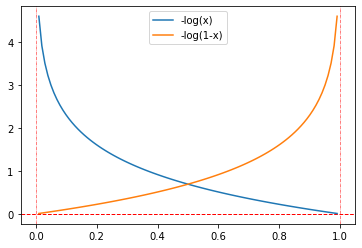

In [84]:
# 크로스 엔트로피 손실 함수 직접 그리기

alpha = 0.1e-1        # 0.1e - 1 로 하면 e 인식 못함
x = np.linspace(0 + alpha, 1 - alpha, 100)
y1 = -np.log(x)
y2 = -np.log(1-x)
 
plt.axhline(y=0, color="r", linestyle="--", linewidth=1)
plt.axvline(x=1, color="r", linestyle="-.", linewidth=.5)
plt.axvline(x=0, color="r", linestyle="-.", linewidth=.5)
 
plt.plot(x, y1, label='-log(x)')
plt.plot(x, y2, label='-log(1-x)')
 
plt.legend()
plt.show()

## 크로스 엔트로피 손실 함수

- **tf.keras.losses.categorical_crossentropy**

  - 정답

    - y_true = [[0, 1, 0], [0, 0, 1]]

  - 예측

    - y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]

  - 함수 적용

    - loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

  - 결과

    - loss.numpy()

```py
import tensorflow as tf

y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]

loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
loss.numpy()
```

In [85]:
## 크로스 엔트로피 손실 함수

y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]

loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
loss.numpy()

# array([0.05129331, 2.3025851], dtype=float32)   ; 2.3025851 - 정답이 2인데, 정답을 1이 0.8로 예측해 손실값이 매우 큼

array([0.05129331, 2.3025851 ], dtype=float32)